<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_direct_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Direct solver

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=e0f6a95fc464bf1c5c5c43efba5af647a0b91e905c0c9d656a57a1171ee6c918
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [2]:
pip install torchdyn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=b5edee45955383bcfbfea03fd6484cdcfb652c42ab958ba0bc5b115ae40aec58
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [3]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
# from torchdyn.numerics.solvers import SolverTemplate

In [4]:
#@title solver 
class SolverTemplate(nn.Module):
    def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
        super().__init__()
        self.order = order
        self.min_factor = torch.tensor([min_factor])
        self.max_factor = torch.tensor([max_factor])
        self.safety = torch.tensor([safety])
        self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        if self.tableau is not None:
            c, a, bsol, berr = self.tableau
            self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
                proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        self.safety = self.safety.to(device)
        self.min_factor = self.min_factor.to(device)
        self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass

class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None


In [5]:
# !git clone https://github.com/juanmggb/maestria.git

In [6]:
# cd maestria

In [7]:
# ls

In [8]:
#@title bioreactor model
def inhibition_model(t, x):
    b = x[:, 0]
    s = x[:, 1]
    p = x[:, 2]

    # Kinetic parameters
    mu = 1.2 # 1/h
    ks = 280 # g/L
    Yxs = 0.2 
    Ypx = 4 
    ki = 0.3

    # Mass balances
    db = mu*(s / (ks + s + ki*s**2))*b 
    ds = -1/Yxs*mu*(s / (ks + s + ki*s**2))*b 
    dp = Ypx*mu*(s / (ks + s + ki*s**2))*b

    return torch.stack((db, ds, dp), dim=-1)

Latin hypercube sampling (LHS) is a method for sampling a multi-dimensional space in a structured way such that each sample is as representative as possible of the space as a whole. It is called a "Latin" hypercube because it is a generalization of the Latin square, a type of matrix used in statistical design and analysis.

In LHS, the range of each dimension is divided into equal intervals, and then a single point is chosen randomly from each interval. This generates a set of samples that covers the entire range of the multi-dimensional space, with a more even distribution of points than would be achieved by simple random sampling.

LHS is often used in computer simulations and statistical modeling to generate a representative sample of a complex space in a computationally efficient way. It can be particularly useful when the dimensions of the space are highly correlated, or when the distribution of the data is non-uniform.

In [9]:
def create_initial_cond(n_training,
                         lower_limit_x,
                         upper_limit_x,
                         lower_limit_s,
                         upper_limit_s,
                         lower_limit_p,
                         upper_limit_p):
    
    x0_train = (
        torch.tensor(lhs(3, n_training), device='cpu') 
    ) 
    x0_train[:,0] = x0_train[:,0] * upper_limit_x + lower_limit_x # biomass (0.2-10.2)
    x0_train[:,1] = x0_train[:,1] * upper_limit_s + lower_limit_s # substrate (0-40)
    x0_train[:,2] = x0_train[:,2] * upper_limit_p + lower_limit_p # product (0-40)
    return x0_train 

1. Create initial condtions for training 

    * 100 initial contions 
    * biomass concentrations goes from 0.2 to 10 g/L
    * substrate concentration goes from 0 to 40 g/L
    * product concentration goes from 0 to 40 g/L

In [10]:
# Initial condtions for training
x0_train = create_initial_cond(100, 0.2, 10, 0, 40, 0, 40)
print(x0_train[:5])
print(x0_train.shape)

tensor([[ 3.8163, 32.4040, 12.6701],
        [ 9.9729, 19.4068, 21.5936],
        [ 8.7610,  0.9129,  5.9480],
        [ 1.4314, 10.8553,  1.3790],
        [ 9.8707, 30.3650, 22.9190]], dtype=torch.float64)
torch.Size([100, 3])


2. Create initial conditions for validations
    * 10 initial conditions 
    * the bondaries are the same as for training 

In [11]:
# Initial conditions to model validation
x0_validate = create_initial_cond(10, 0.2, 10, 0, 40, 0, 40)
print(x0_validate[:5])
print(x0_validate.shape)

tensor([[ 5.7159, 32.7574, 12.6032],
        [ 4.5506,  7.0443,  5.1394],
        [ 9.3213, 16.6209, 31.2431],
        [ 7.7940, 28.9887, 35.8246],
        [ 0.6797, 37.0149, 11.0932]], dtype=torch.float64)
torch.Size([10, 3])


In [12]:
def create_time_span(start_time, end_time, step_size):
    ε = 1e-10 
    t_span = torch.arange(
        start_time, 
        end_time + ε,
        step_size
    )
    return t_span

3. Create time span for training
    * It is a time span of 1 hour

4. Create time span for validations 
    * It is a time span of 60 hours 

In [13]:
# training time are time intervals of 1 hour
t_span_train = create_time_span(0, 1, 1)
# validation time are time intervals of 60 hours
t_span_validate = create_time_span(0, 60, 1)

5. Generate training trajectories
    * Each trajectory consists on the initial conditions and one step haead
    * RK4 is used to generate trajectory

In [14]:
# Calculate state at hour 1 with training initial conditions
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model, x0_train, t_span_train, solver="rk4")
print(x_train.shape)

torch.Size([2, 100, 3])


In [15]:
# Function to plot trajectory
def plot_trajectory(n, trajectories):
    if n == 0:
        plt.plot(trajectories[:, n, 0], label='biomass', color="lightgreen")
        plt.plot(trajectories[:, n, 1], label='substrate', color="#F97306")
        plt.plot(trajectories[:, n, 2], label='product', color="#069AF3")
    else: 
        plt.plot(trajectories[:, n, 0], color="lightgreen")
        plt.plot(trajectories[:, n, 1], color="#F97306")
        plt.plot(trajectories[:, n, 2], color="#069AF3")

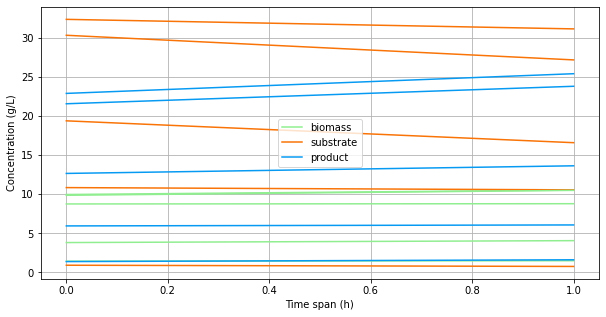

In [16]:
# Plot trajectory i from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

6. Generate validate trajectories 
    * Each trajectory consists of 60 observations, starting with the initial conditions 
    * RK4 is used to generate trajectories 

In [17]:
# Calculate trajectory for initial conditions in validation data
_, x_validate = odeint(inhibition_model, x0_validate, t_span_validate, solver="rk4")
print(x_validate.shape)

torch.Size([61, 10, 3])


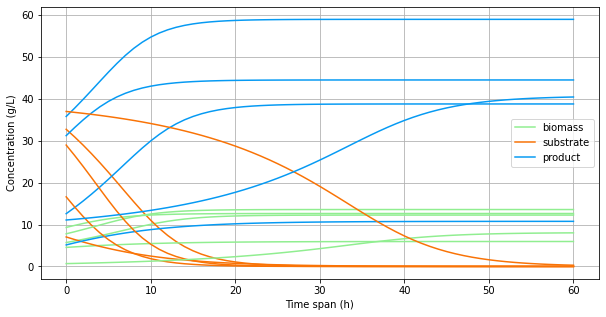

In [18]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

7. Generate ANN model 
    
    * 7.1 One input layer with three input neurons and 32 output neurons 

    * 7.2 Eight hidden layers with 32 neurons 

      * Each hidden layer consists of a Linear layer with a Softplus activations functions 

    * 7.3 The output has 32 input neurons and three output neurons 
        * The output layers is a simple Linear layer without activations function

    * 7.4 The weights and biases of the ANN are randomly initialized 


In [19]:
def fnn_model(input_dim, output_dim, hidden_dim, hidden_layers):
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    for _ in range(hidden_layers):
        layers.append(nn.Linear(hidden_dim, hidden_dim)) 
        layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, output_dim))
    net = nn.Sequential(*layers) 
    net.to('cpu').double()

    for m in net.modules():
        if type(m) == nn.Linear:
            # Initialize the weights of the Linear module using xavier_uniform_
            nn.init.xavier_uniform_(m.weight)
    return net

In [20]:
# Create model
net = fnn_model(3, 3, 32, 8)

8. The optimization algorithm for training is Adam 

Adam (Adaptive Moment Estimation) is an optimization algorithm commonly used in deep learning. It combines the advantages of two other popular optimization algorithms, SGD (Stochastic Gradient Descent) and RMSprop (Root Mean Squared Propagation), and has been shown to work well in a wide range of applications.

The Adam optimization algorithm uses estimates of the first and second moments of the gradients to scale the learning rate adaptively. This can help the optimizer converge more quickly and avoid oscillations or divergences that can occur with other optimization algorithms. It also includes a learning rate decay schedule, which decreases the learning rate over time to help the optimizer converge to a more optimal solution.

In [21]:
# training algorithm
optimizer = Adam(net.parameters()) 

9. The loss function is the MSE

10. During training the loss function for the training and the validations data is calculates

11. The training occurs by two hundred epochs 

In [22]:
import time

In [23]:
strat_time = time.time()
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver=DirectSolver()
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    # Validation data
    net.eval()
    with torch.inference_mode():

        # 1. Forward pass
        _, x_pred_validate = odeint(
            lambda t, x: net(x), 
            x0_validate, 
            t_span_validate, 
            solver=DirectSolver()
        )

        # 2. Calculate loss
        loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss} | Validate loss: {loss_val}")
end_time = time.time()

  0%|          | 5/2000 [00:00<01:24, 23.54it/s]

Epoch: 0 | Training loss: 168.93534727233632 | Validate loss: 448.67351482954126


  3%|▎         | 56/2000 [00:01<00:51, 37.67it/s]

Epoch: 50 | Training loss: 11.144332946352346 | Validate loss: 259.76826727639997


  5%|▌         | 106/2000 [00:02<00:44, 42.43it/s]

Epoch: 100 | Training loss: 2.3619277069998716 | Validate loss: 45.15236084514082


  8%|▊         | 154/2000 [00:04<01:23, 22.10it/s]

Epoch: 150 | Training loss: 0.37474720161646613 | Validate loss: 2409.5328421141817


 10%|█         | 205/2000 [00:06<01:19, 22.45it/s]

Epoch: 200 | Training loss: 0.06569022116916438 | Validate loss: 324.2987102193263


 13%|█▎        | 253/2000 [00:08<01:36, 18.18it/s]

Epoch: 250 | Training loss: 0.029094847955592997 | Validate loss: 376.08901427587847


 15%|█▌        | 304/2000 [00:11<01:25, 19.79it/s]

Epoch: 300 | Training loss: 0.017159198617036887 | Validate loss: 620.498262734864


 18%|█▊        | 356/2000 [00:13<01:13, 22.49it/s]

Epoch: 350 | Training loss: 0.010610277614615953 | Validate loss: 458.68687186113743


 20%|██        | 409/2000 [00:15<00:37, 41.90it/s]

Epoch: 400 | Training loss: 0.007328541271233868 | Validate loss: 441.18762981245203


 23%|██▎       | 459/2000 [00:16<00:34, 45.15it/s]

Epoch: 450 | Training loss: 0.008605315771798398 | Validate loss: 419.59725325535857


 25%|██▌       | 509/2000 [00:17<00:33, 45.16it/s]

Epoch: 500 | Training loss: 0.003976923652364274 | Validate loss: 265.4909667077497


 28%|██▊       | 559/2000 [00:18<00:31, 45.07it/s]

Epoch: 550 | Training loss: 0.003555198039248408 | Validate loss: 194.03409353992447


 30%|███       | 609/2000 [00:20<00:31, 44.34it/s]

Epoch: 600 | Training loss: 0.002643429932260987 | Validate loss: 164.45120869394566


 33%|███▎      | 659/2000 [00:21<00:30, 44.60it/s]

Epoch: 650 | Training loss: 0.0028207821276842048 | Validate loss: 151.3038228170583


 35%|███▌      | 709/2000 [00:22<00:28, 45.63it/s]

Epoch: 700 | Training loss: 0.001982801745068105 | Validate loss: 138.1014706512879


 38%|███▊      | 759/2000 [00:23<00:27, 45.03it/s]

Epoch: 750 | Training loss: 0.0031729388213957922 | Validate loss: 50.42286997350267


 40%|████      | 809/2000 [00:24<00:26, 45.25it/s]

Epoch: 800 | Training loss: 0.0016237281132098769 | Validate loss: 149.49022472128456


 43%|████▎     | 859/2000 [00:25<00:25, 44.35it/s]

Epoch: 850 | Training loss: 0.0014134423613078016 | Validate loss: 139.95615849808925


 45%|████▌     | 909/2000 [00:26<00:24, 44.88it/s]

Epoch: 900 | Training loss: 0.0024282545729432635 | Validate loss: 128.78548383245496


 48%|████▊     | 959/2000 [00:27<00:23, 44.82it/s]

Epoch: 950 | Training loss: 0.0011879782039651314 | Validate loss: 126.06367100919928


 50%|█████     | 1009/2000 [00:28<00:22, 44.74it/s]

Epoch: 1000 | Training loss: 0.0010716401875375565 | Validate loss: 125.33998733253144


 53%|█████▎    | 1059/2000 [00:30<00:21, 43.63it/s]

Epoch: 1050 | Training loss: 0.019129688431451 | Validate loss: 88.26347345841594


 55%|█████▌    | 1109/2000 [00:31<00:22, 39.43it/s]

Epoch: 1100 | Training loss: 0.0010038055844485822 | Validate loss: 102.65154649087347


 58%|█████▊    | 1159/2000 [00:32<00:18, 45.64it/s]

Epoch: 1150 | Training loss: 0.0008266884373199391 | Validate loss: 104.10294174183296


 60%|██████    | 1209/2000 [00:33<00:17, 45.52it/s]

Epoch: 1200 | Training loss: 0.0007533935176639732 | Validate loss: 96.7322009218251


 63%|██████▎   | 1259/2000 [00:34<00:15, 46.82it/s]

Epoch: 1250 | Training loss: 0.0009087462847674327 | Validate loss: 95.69252231424682


 65%|██████▌   | 1309/2000 [00:36<00:15, 45.91it/s]

Epoch: 1300 | Training loss: 0.0006714031158274341 | Validate loss: 87.23713630279603


 68%|██████▊   | 1359/2000 [00:37<00:13, 46.45it/s]

Epoch: 1350 | Training loss: 0.0006019804345914043 | Validate loss: 83.4166674149119


 70%|███████   | 1409/2000 [00:38<00:13, 45.10it/s]

Epoch: 1400 | Training loss: 0.0005534392718903997 | Validate loss: 80.39596873283395


 73%|███████▎  | 1459/2000 [00:39<00:12, 44.41it/s]

Epoch: 1450 | Training loss: 0.02412018371431826 | Validate loss: 58.53646424919058


 75%|███████▌  | 1509/2000 [00:40<00:10, 44.84it/s]

Epoch: 1500 | Training loss: 0.0006720087311673186 | Validate loss: 69.29020775120769


 78%|███████▊  | 1559/2000 [00:41<00:10, 44.00it/s]

Epoch: 1550 | Training loss: 0.0004750258324465307 | Validate loss: 71.13472182911433


 80%|████████  | 1609/2000 [00:42<00:08, 45.32it/s]

Epoch: 1600 | Training loss: 0.00043875072436339247 | Validate loss: 69.35523897717535


 83%|████████▎ | 1659/2000 [00:43<00:07, 43.42it/s]

Epoch: 1650 | Training loss: 0.0004090323630602486 | Validate loss: 67.80233229683307


 85%|████████▌ | 1709/2000 [00:45<00:06, 43.64it/s]

Epoch: 1700 | Training loss: 0.0014105934539778476 | Validate loss: 40.071848210374085


 88%|████████▊ | 1759/2000 [00:46<00:05, 43.99it/s]

Epoch: 1750 | Training loss: 0.018800483414415287 | Validate loss: 38.1301603897472


 90%|█████████ | 1809/2000 [00:47<00:04, 45.24it/s]

Epoch: 1800 | Training loss: 0.0003731480035786425 | Validate loss: 67.7916744464882


 93%|█████████▎| 1859/2000 [00:48<00:03, 44.34it/s]

Epoch: 1850 | Training loss: 0.00034041247835130535 | Validate loss: 68.60926398860879


 95%|█████████▌| 1909/2000 [00:49<00:02, 45.10it/s]

Epoch: 1900 | Training loss: 0.0013207236996237175 | Validate loss: 73.16720127305412


 98%|█████████▊| 1959/2000 [00:50<00:00, 44.87it/s]

Epoch: 1950 | Training loss: 0.0008597755657171265 | Validate loss: 72.96794084733665


100%|██████████| 2000/2000 [00:51<00:00, 38.82it/s]


In [24]:
total_time = end_time - strat_time 
print(f"Total time: {total_time:.3f}s")

Total time: 51.533s


12. The minimum loss function achieved with the training data is  0.000429

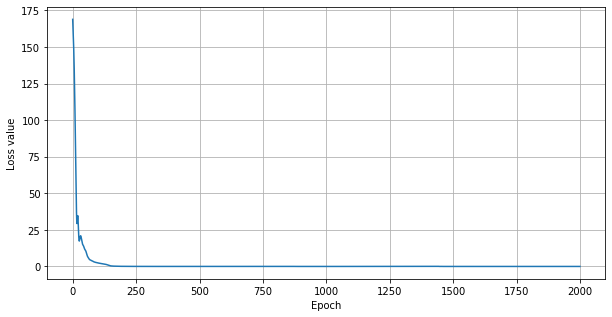

In [25]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [26]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver=DirectSolver()
    ) 

In [27]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


In [28]:
print(mse_loss(x_pred_validate, x_validate))

tensor(71.2201, dtype=torch.float64)


13. The minimum loss function achieved with the validation data is 18.1128

In [29]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

In [30]:
def plot_predictions(n=0):

    print("Validación", n)

    # Create figure
    plt.figure(figsize = (25,5))

    # plot biomass
    plt.subplot(131)
    plt.plot(t_span_validate, 
        x_validate[:, n, 0], 
        color="#069AF3", label = 'Mechanistic model', linewidth = 5)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate, 
        x_validate[:, n, 1], 
        color="#F97306", label = 'Mechanistic model', linewidth = 5)

    # plot ethanol
    plt.subplot(133)
    plt.plot(t_span_validate, 
            x_validate[:, n, 2], 
            color="lightgreen", label = 'Mechanistic model', linewidth = 5)


    # plot biomass
    plt.subplot(131)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 0], label = 'ANN', 
        linestyle="dashed",
        color="#069AF3", linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Biomass", size = 20)
    plt.legend(fontsize = 20)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 1], label = 'ANN', 
        linestyle="dashed",
        color='#F97306', linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Substrate", size = 20)
    plt.legend(fontsize = 20)

    # plot ethanol
    plt.subplot(133)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 2], label = 'ANN', 
        linestyle="dashed",
        color="lightgreen", linewidth = 5)

    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Ethanol", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

Validación 0


<ipython-input-30-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-30-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-30-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

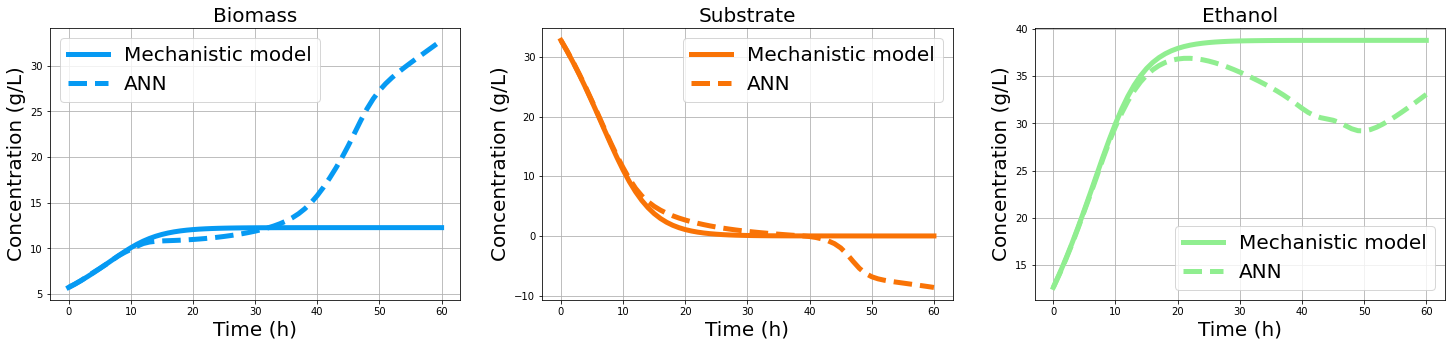

Validación 1


<ipython-input-30-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-30-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-30-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

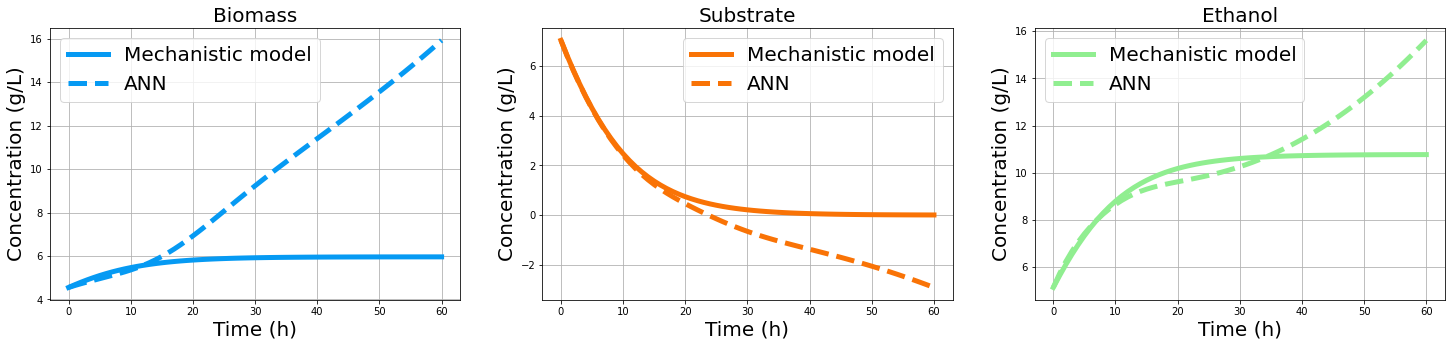

Validación 2


<ipython-input-30-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-30-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-30-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

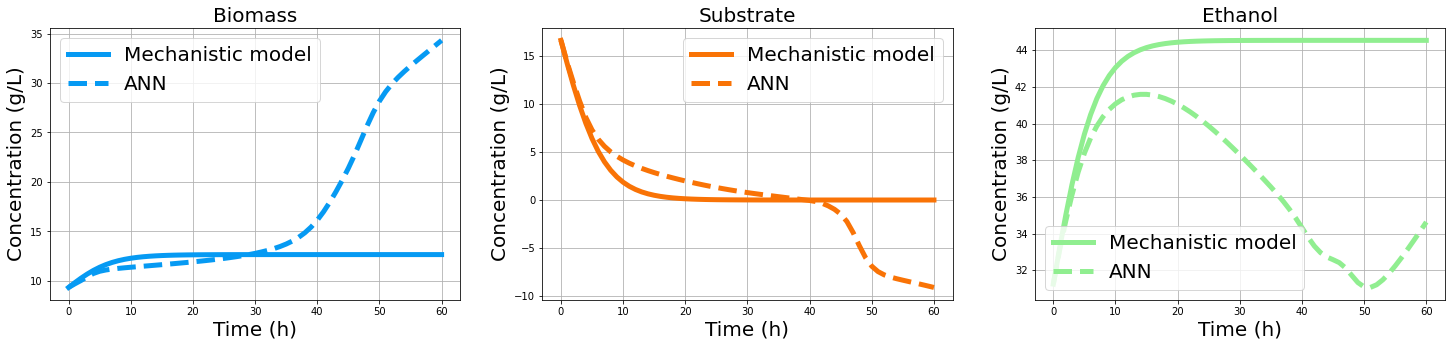

Validación 3


<ipython-input-30-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-30-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-30-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

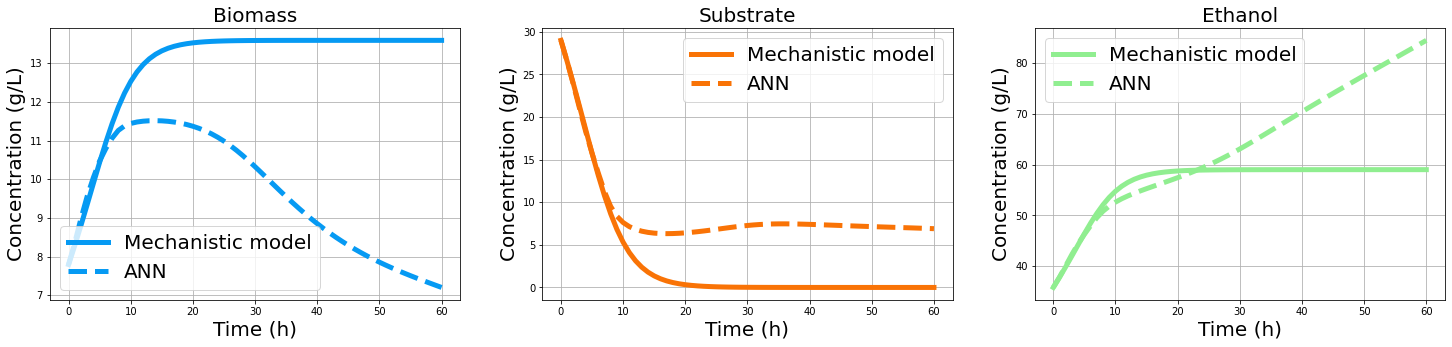

Validación 4


<ipython-input-30-5b83fc592c87>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-30-5b83fc592c87>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-30-5b83fc592c87>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

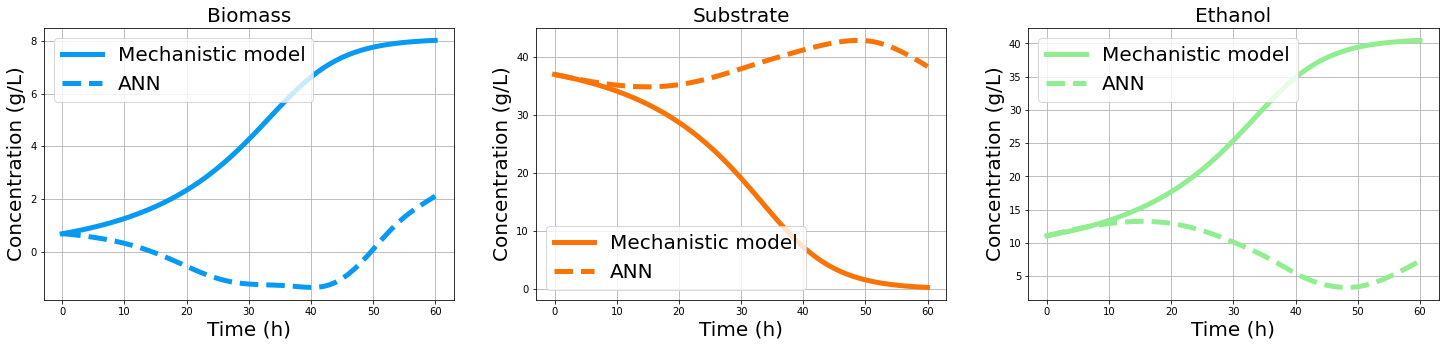

In [31]:
for i in range(5):
    plot_predictions(i)